# MIMIC-IV Core Table Analysis
This notebook analyzes the mimic core tables, after they've been transformed to the `mimic_mm_core` view.

In [ ]:
# Removes lint errors from VS Code
from typing import Dict, TYPE_CHECKING, Tuple, List

if TYPE_CHECKING:
    import kedro
    catalog: kedro.io.data_catalog.DataCatalog
    session: kedro.framework.session.session.KedroSession
    catalog: kedro.io.data_catalog.DataCatalog
    pipelines: Dict[str, kedro.pipeline.pipeline.Pipeline]

# Plotting
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

plt.style.use("./utils/light.mplstyle")
plt.rcParams['figure.figsize'] = [6, 4]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Imports
import numpy as np
import pandas as pd

def subplots_row(cols) -> Tuple[plt.Figure, List[plt.Axes]]:
    w, h = plt.rcParams['figure.figsize']
    margin = plt.rcParams["figure.subplot.wspace"]
    return *plt.subplots(1, cols, figsize=(w*cols + margin*(cols-1), h)), 0

In [ ]:
# Load data with kedro
patients: pd.DataFrame = catalog.load('mimic_mm_core.view.patients')
admissions: pd.DataFrame = catalog.load('mimic_mm_core.view.admissions')
transfers: pd.DataFrame = catalog.load('mimic_mm_core.view.transfers')

len(patients), len(admissions), len(transfers)

2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.patients` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.admissions` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.transfers` (ParquetDataSet)...


(382278, 523740, 1840982)

In [ ]:
from ipywidgets import interact
from pandas.api.types import is_datetime64_any_dtype as is_datetime, is_timedelta64_dtype as is_timedelta

def is_cat(series):
    return str(series.dtype) in ('category', 'object', 'bool')

def create_2d_viz(table: pd.DataFrame, dropcols=['subject_id', 'hadm_id', 'transfer_id']):
    cmap = 'Blues'

    def gen_dist(x, y):
        full_table = table.dropna()
        x, y = full_table[x], full_table[y]

        # Convert timedeltas to days
        if is_timedelta(x):
            x = x.dt.days / 365
        if is_timedelta(y):
            y = y.dt.days / 365
        
        if is_cat(x) and is_cat(y):
            chart = pd.crosstab(x, y).style.background_gradient(cmap=cmap)
        elif is_cat(x) or is_cat(y):
            # Make x categorical
            x, y = (x, y) if is_cat(x) else (y, x)
            chart, ax = plt.subplots()

            vals = list(x.unique())
            ax.hist([y[x == val] for val in vals], histtype='bar', rwidth=0.9, label=vals)
            ax.legend()
        else:
            chart, ax = plt.subplots()
            ax.hexbin(x, y, cmap=cmap)
        
        return chart

    keys = [key for key in table.keys() if key not in dropcols]
    interact(gen_dist, x=keys, y=keys)

In [ ]:
# Sensitive
create_2d_viz(patients)

## Patients Table Analysis

In [ ]:
# Sensitive
patients.dropna().head()

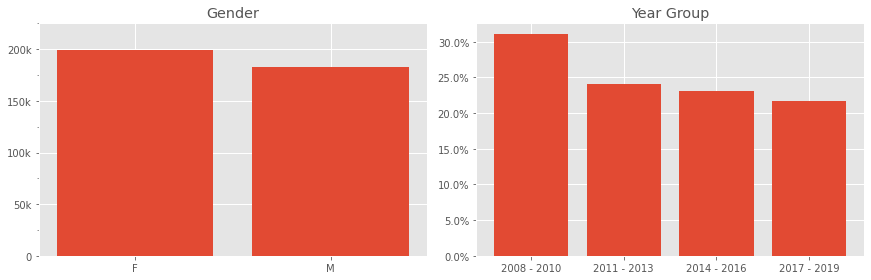

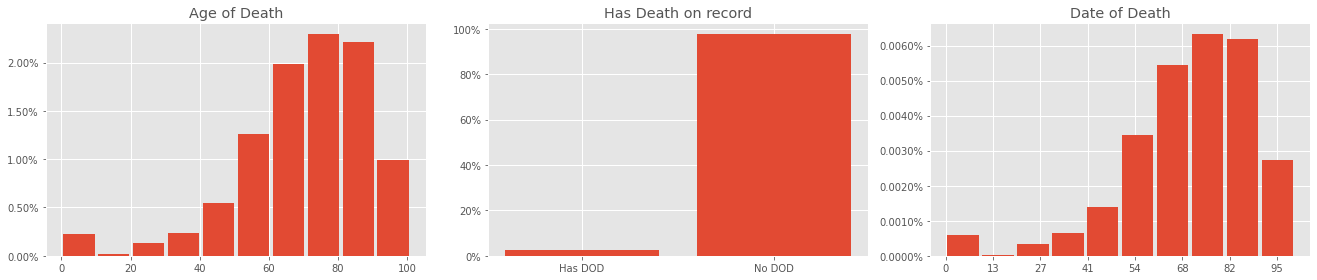

In [ ]:
fig, ax, i = subplots_row(2)
counts = patients.value_counts('gender')
ax[i].set_title('Gender')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(25000))
ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '%dk' % (x / 1000) if x else '0'))
ax[i].set_ylim([0, 225000])

i += 1
counts = patients.value_counts('year_group')
counts /= np.sum(counts)
ax[i].set_title('Year Group')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0)) 
fig.tight_layout()

# i += 1
# ax[i].hist(patients['anchor_age'], density=True, rwidth=0.9)
# ax[i].set_title('Age')
# ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0)) 

fig, ax, i = subplots_row(3)
ax[i].hist(patients['death_age'].dropna(), density=True, rwidth=0.9)
ax[i].set_title('Age of Death')
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

i += 1
total = len(patients)
no_dod = patients['death_date'].isnull().sum() / total
ax[i].set_title('Has Death on record')
ax[i].bar(['Has DOD', "No DOD"], [1-no_dod, no_dod])
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

i += 1
ax[i].hist(patients['death_date'].dropna().dt.days, density=True, rwidth=0.9)
ax[i].set_title('Date of Death')
ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x / 365))) 
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0)) 
fig.tight_layout()

# i += 1
# ax[i].set_title('Death after N Years from first admission')
# ax[i].hist(patients['dod'].dropna().dt.days, density=True, rwidth=0.9)
# ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x / 365))) 
# ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0)) 



In [ ]:
# Sensitive
create_2d_viz(patients)

## Admissions Table Analysis

In [ ]:
# Sensitive
admissions.dropna().head()

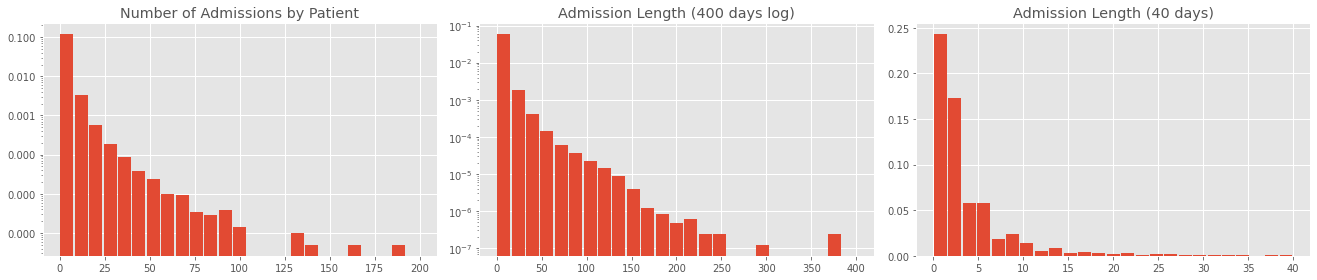

In [ ]:
fig, ax, i = subplots_row(3)
counts = admissions.groupby('subject_id')['subject_id'].count()
ax[i].set_title('Number of Admissions by Patient')
ax[i].hist(counts, range=(0, 200), log=True, density=True, bins=25, rwidth=0.9)
ax[i].yaxis.set_major_formatter(ticker.ScalarFormatter())

i += 1
admission_length = admissions['dischtime'] - admissions['admittime']
ax[i].set_title('Admission Length (400 days log)')
ax[i].hist(admission_length.dt.days, range=(0, 400), density=True, log=True, bins=25, rwidth=0.9)

i += 1
ax[i].set_title('Admission Length (40 days)')
ax[i].hist(admission_length.dt.days, range=(0, 40), density=True, bins=25, rwidth=0.9)

fig.tight_layout()

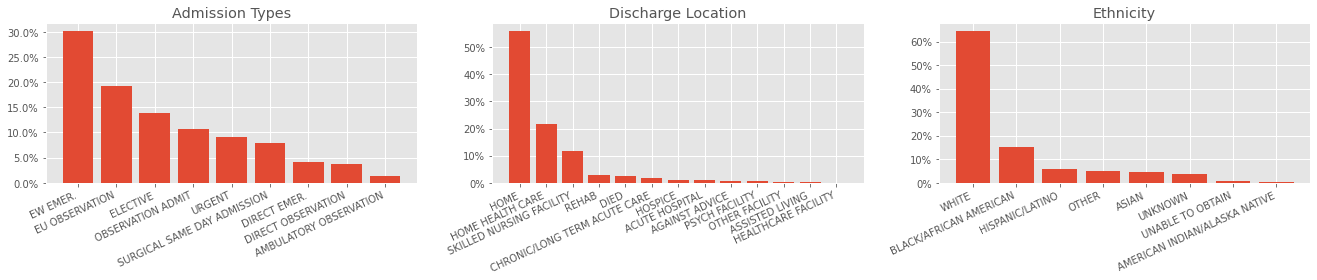

In [ ]:
fig, ax, i = subplots_row(3)

counts = admissions.value_counts('admission_type')
counts /= np.sum(counts)
ax[i].set_title('Admission Types')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

i += 1
counts = admissions.value_counts('discharge_location')
counts /= np.sum(counts)
ax[i].set_title('Discharge Location')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

i += 1
counts = admissions.value_counts('ethnicity')
counts /= np.sum(counts)
ax[i].set_title('Ethnicity')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

fig.tight_layout()

In [ ]:
# sensitive
admissions[admissions['admittime']==admissions['admittime'].min()]

In [ ]:
# There is a small number of admissions that occured before the anchor year
len(admissions[admissions['admittime'].dt.days < 0])

0

In [ ]:
# Sensitive
create_2d_viz(admissions)

## Transfers Table Analysis

In [ ]:
# Sensitive
transfers.dropna().head()

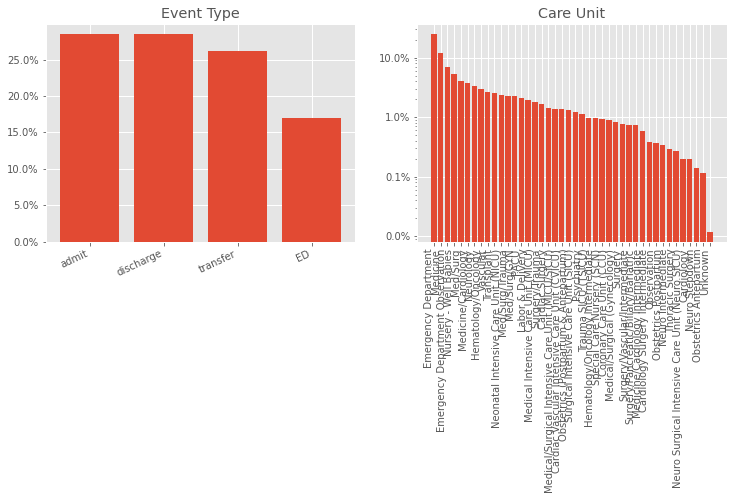

In [ ]:
fig, ax, i = subplots_row(2)

counts = transfers.value_counts('eventtype')
counts /= np.sum(counts)
ax[i].set_title('Event Type')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

i += 1
counts = transfers.value_counts('careunit')
counts /= np.sum(counts)
ax[i].set_title('Care Unit')
ax[i].bar(list(counts.keys()), list(counts.values), log=True)
ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=90, horizontalalignment='right');


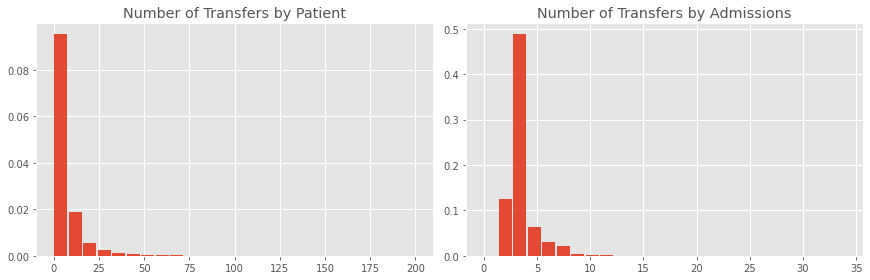

In [ ]:
fig, ax, i = subplots_row(2)
counts = transfers.groupby('subject_id')['subject_id'].count()
ax[i].set_title('Number of Transfers by Patient')
ax[i].hist(counts, range=(0, 200), log=False, density=True, bins=25, rwidth=0.9)
ax[i].yaxis.set_major_formatter(ticker.ScalarFormatter())

i += 1
counts = transfers.groupby('hadm_id')['hadm_id'].count()
ax[i].set_title('Number of Transfers by Admissions')
ax[i].hist(counts, range=(0, 34), log=False, density=True, bins=25, rwidth=0.9)
ax[i].yaxis.set_major_formatter(ticker.ScalarFormatter())

fig.tight_layout()